In [105]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import Levenshtein as lev
import graphviz
import pydotplus
from networkx.drawing.nx_pydot import graphviz_layout

In [4]:
pv = pd.read_csv("protVec_100d_3grams.csv.gz", sep="\\t", header=None)
protvec = {}
for row in pv.iterrows():
    row = list(list(row)[1])
    row[-1] = float(row[-1][:-1])
    protvec[row[0][1:]] = np.array(row[1:], dtype=float)

def compute_vec(seq, protvec = protvec):
    res = np.array([0] * 100, dtype=float)
    for i in range(len(seq) - 2):
        res += protvec[seq[i:i+3]]
    return res

db_orig = pd.read_csv("../vdjdb-db/database/vdjdb.slim.txt", sep="\t")
v1 = db_orig.groupby(["gene", "species", "antigen.species"]).get_group(("TRB", "HomoSapiens", "CMV"))
v2 = db_orig.groupby(["gene", "species", "antigen.species"]).get_group(("TRB", "HomoSapiens", "EBV"))
v3 = db_orig.groupby(["gene", "species", "antigen.species"]).get_group(("TRB", "HomoSapiens", "HIV-1"))
v4 = db_orig.groupby(["gene", "species", "antigen.species"]).get_group(("TRB", "HomoSapiens", "HCV"))

v5 = db_orig.groupby(["gene", "species", "antigen.species"]).get_group(("TRB", "MacacaMulatta", "HIV-1"))
v5["antigen.species"] = "HIV-1-mm"
v6 = db_orig.groupby(["gene", "species", "antigen.species"]).get_group(("TRB", "MacacaMulatta", "SIV"))
db = pd.concat([v1, v2, v3, v4, v5, v6])
db_vec = np.array(list(map(compute_vec, db["cdr3"])))

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [103]:
import random 

MAX_DIST = 3

G = nx.Graph()

edges = []
labels = {}
colors_classes = {x: random.random() for x in db["antigen.species"]}
colors = {x: [] for x in color_classes}
nodes = {x: [] for x in color_classes}

for i in range(len(db) - 1):
    for j in range(i + 1, len(db)):
        if (db["v.segm"].iloc[i] == db["v.segm"].iloc[j]) and (lev.distance(db["cdr3"].iloc[i], db["cdr3"].iloc[j]) <= MAX_DIST):
            edges.append((i, j))
            labels[i] = db["antigen.species"].iloc[i]
            labels[j] = db["antigen.species"].iloc[j]
            colors[db["antigen.species"].iloc[i]].append(colors_classes[db["antigen.species"].iloc[i]])
            colors[db["antigen.species"].iloc[j]].append(colors_classes[db["antigen.species"].iloc[j]])
            nodes[db["antigen.species"].iloc[i]].append(i)
            nodes[db["antigen.species"].iloc[j]].append(j)
            G.add_edge(i, j)
            
# break after i>1000 -> 2190-8400  w/o V segments
# break after i>1000 -> 787-1393   w/  V segments
# break after i>2000 -> 1621-4315  w/  V segments
# full               -> 2683-14563 w/  V segments
print(G.number_of_nodes(), G.number_of_edges())

from collections import Counter
Counter(len(x) for x in nx.connected_component_subgraphs(G))

500
1000
1500
2000
2500
3000
3500
4000
2683 14563


Counter({2: 245,
         3: 61,
         4: 27,
         5: 16,
         6: 11,
         7: 7,
         8: 8,
         9: 3,
         10: 5,
         11: 3,
         12: 4,
         13: 3,
         14: 3,
         15: 5,
         16: 2,
         17: 2,
         18: 3,
         20: 2,
         21: 1,
         22: 1,
         23: 2,
         27: 1,
         28: 1,
         30: 1,
         34: 1,
         37: 1,
         38: 1,
         43: 1,
         45: 2,
         49: 1,
         51: 1,
         65: 1,
         80: 1,
         81: 1,
         118: 1,
         136: 1,
         173: 1})

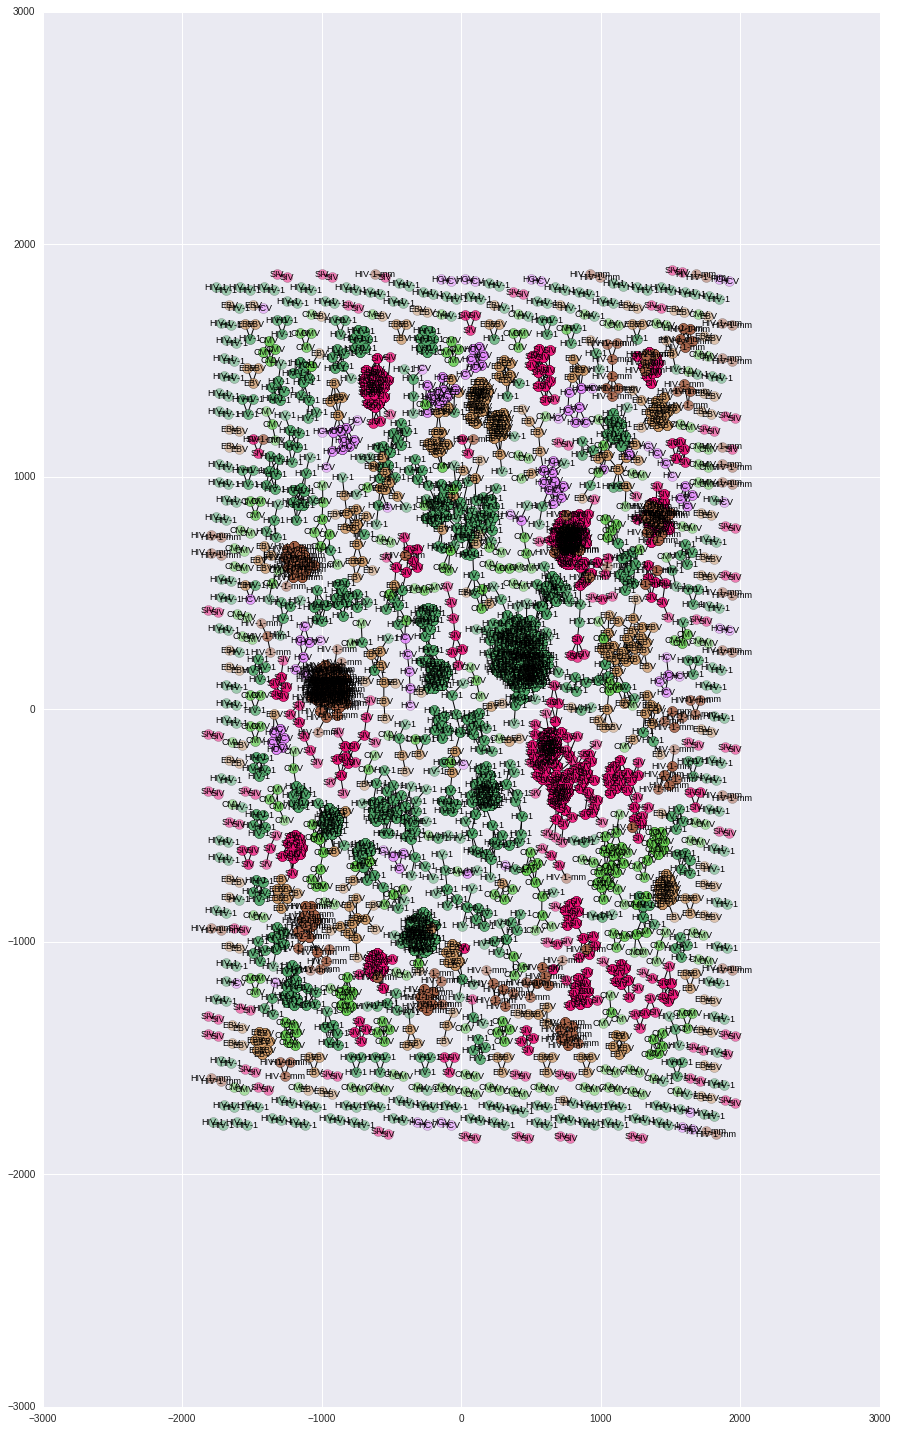

In [104]:
plt.figure(1, figsize=(15, 25))
pos = graphviz_layout(G, prog="neato")
for ag in color_classes:
    nx.draw_networkx_nodes(G, 
                           pos,
                           nodes[ag],
                           node_color=[random.random(), random.random(), random.random()], 
                           node_size = 100, 
                           alpha = .5)
nx.draw_networkx_labels(G, 
                        pos, 
                        labels, 
                        font_size = 9)
nx.draw_networkx_edges(G, pos)

Building the mutation network with the incorporated information about V segments clearly allows us to disinguish among clusters of antigen-specific sequences.